# OIC-201
This project is a collaboration with Arlene Garcia (Patel lab). The goal of this script is to identify the mitochondrial network and mtDNA puncta in images of C. elegans.

The dataset was taken on a spinning disk confocal. Images were acquired at different z-planes, however as the images were not originally intended for 3D analysis, the step size is large. 

Each image has two channels:
- Channel 0 - mitochondria
- Channel 1 - mtDNA

This script will process all ND2 images in the given ``data_directory``, returning the results in ``output_directory``.

## Analysis
* Normalized area of the tail region imaged covered by the mitochondria (3D)
* Density measurement of the nucleoid puncta in the mito signal (3D)
* Signed distance of the nucleoid centroids to the mito network (3D)

In [4]:
# Settings

# Path to image folder
data_directory = ("..\\data\\Day 1 adult animals")

output_directory = ("..\\measurements\\2025-11-26")

# Sensitivity for segmentation (higher number means less pixels in objects)
sensitivity = 2

In [5]:
# Start processing

from bioio import BioImage
from matplotlib import pyplot as plt
import numpy as np
import skimage
from scipy import stats, ndimage
import pandas as pd
import math
import csv
import random
import os
import segmentation # Contains the segmentation scripts

Processing D1A_rep 1.nd2
Processing D1A_rep 10.nd2
Processing D1A_rep 11.nd2


C:\Users\jian.tay\AppData\Local\Temp\ipykernel_10808\3612675060.py:109: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(32, 24))


Processing D1A_rep 12.nd2


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

<Figure size 3200x2400 with 0 Axes>

<Figure size 3200x2400 with 0 Axes>

<Figure size 3200x2400 with 0 Axes>

<Figure size 3200x2400 with 0 Axes>

<Figure size 3200x2400 with 0 Axes>

<Figure size 3200x2400 with 0 Axes>

<Figure size 3200x2400 with 0 Axes>

<Figure size 3200x2400 with 0 Axes>

<Figure size 3200x2400 with 0 Axes>

<Figure size 3200x2400 with 0 Axes>

<Figure size 3200x2400 with 0 Axes>

<Figure size 3200x2400 with 0 Axes>

<Figure size 3200x2400 with 0 Axes>

<Figure size 3200x2400 with 0 Axes>

<Figure size 3200x2400 with 0 Axes>

<Figure size 3200x2400 with 0 Axes>

<Figure size 3200x2400 with 0 Axes>

<Figure size 3200x2400 with 0 Axes>

<Figure size 3200x2400 with 0 Axes>

<Figure size 3200x2400 with 0 Axes>

<Figure size 3200x2400 with 0 Axes>

<Figure size 3200x2400 with 0 Axes>

<Figure size 3200x2400 with 0 Axes>

<Figure size 3200x2400 with 0 Axes>

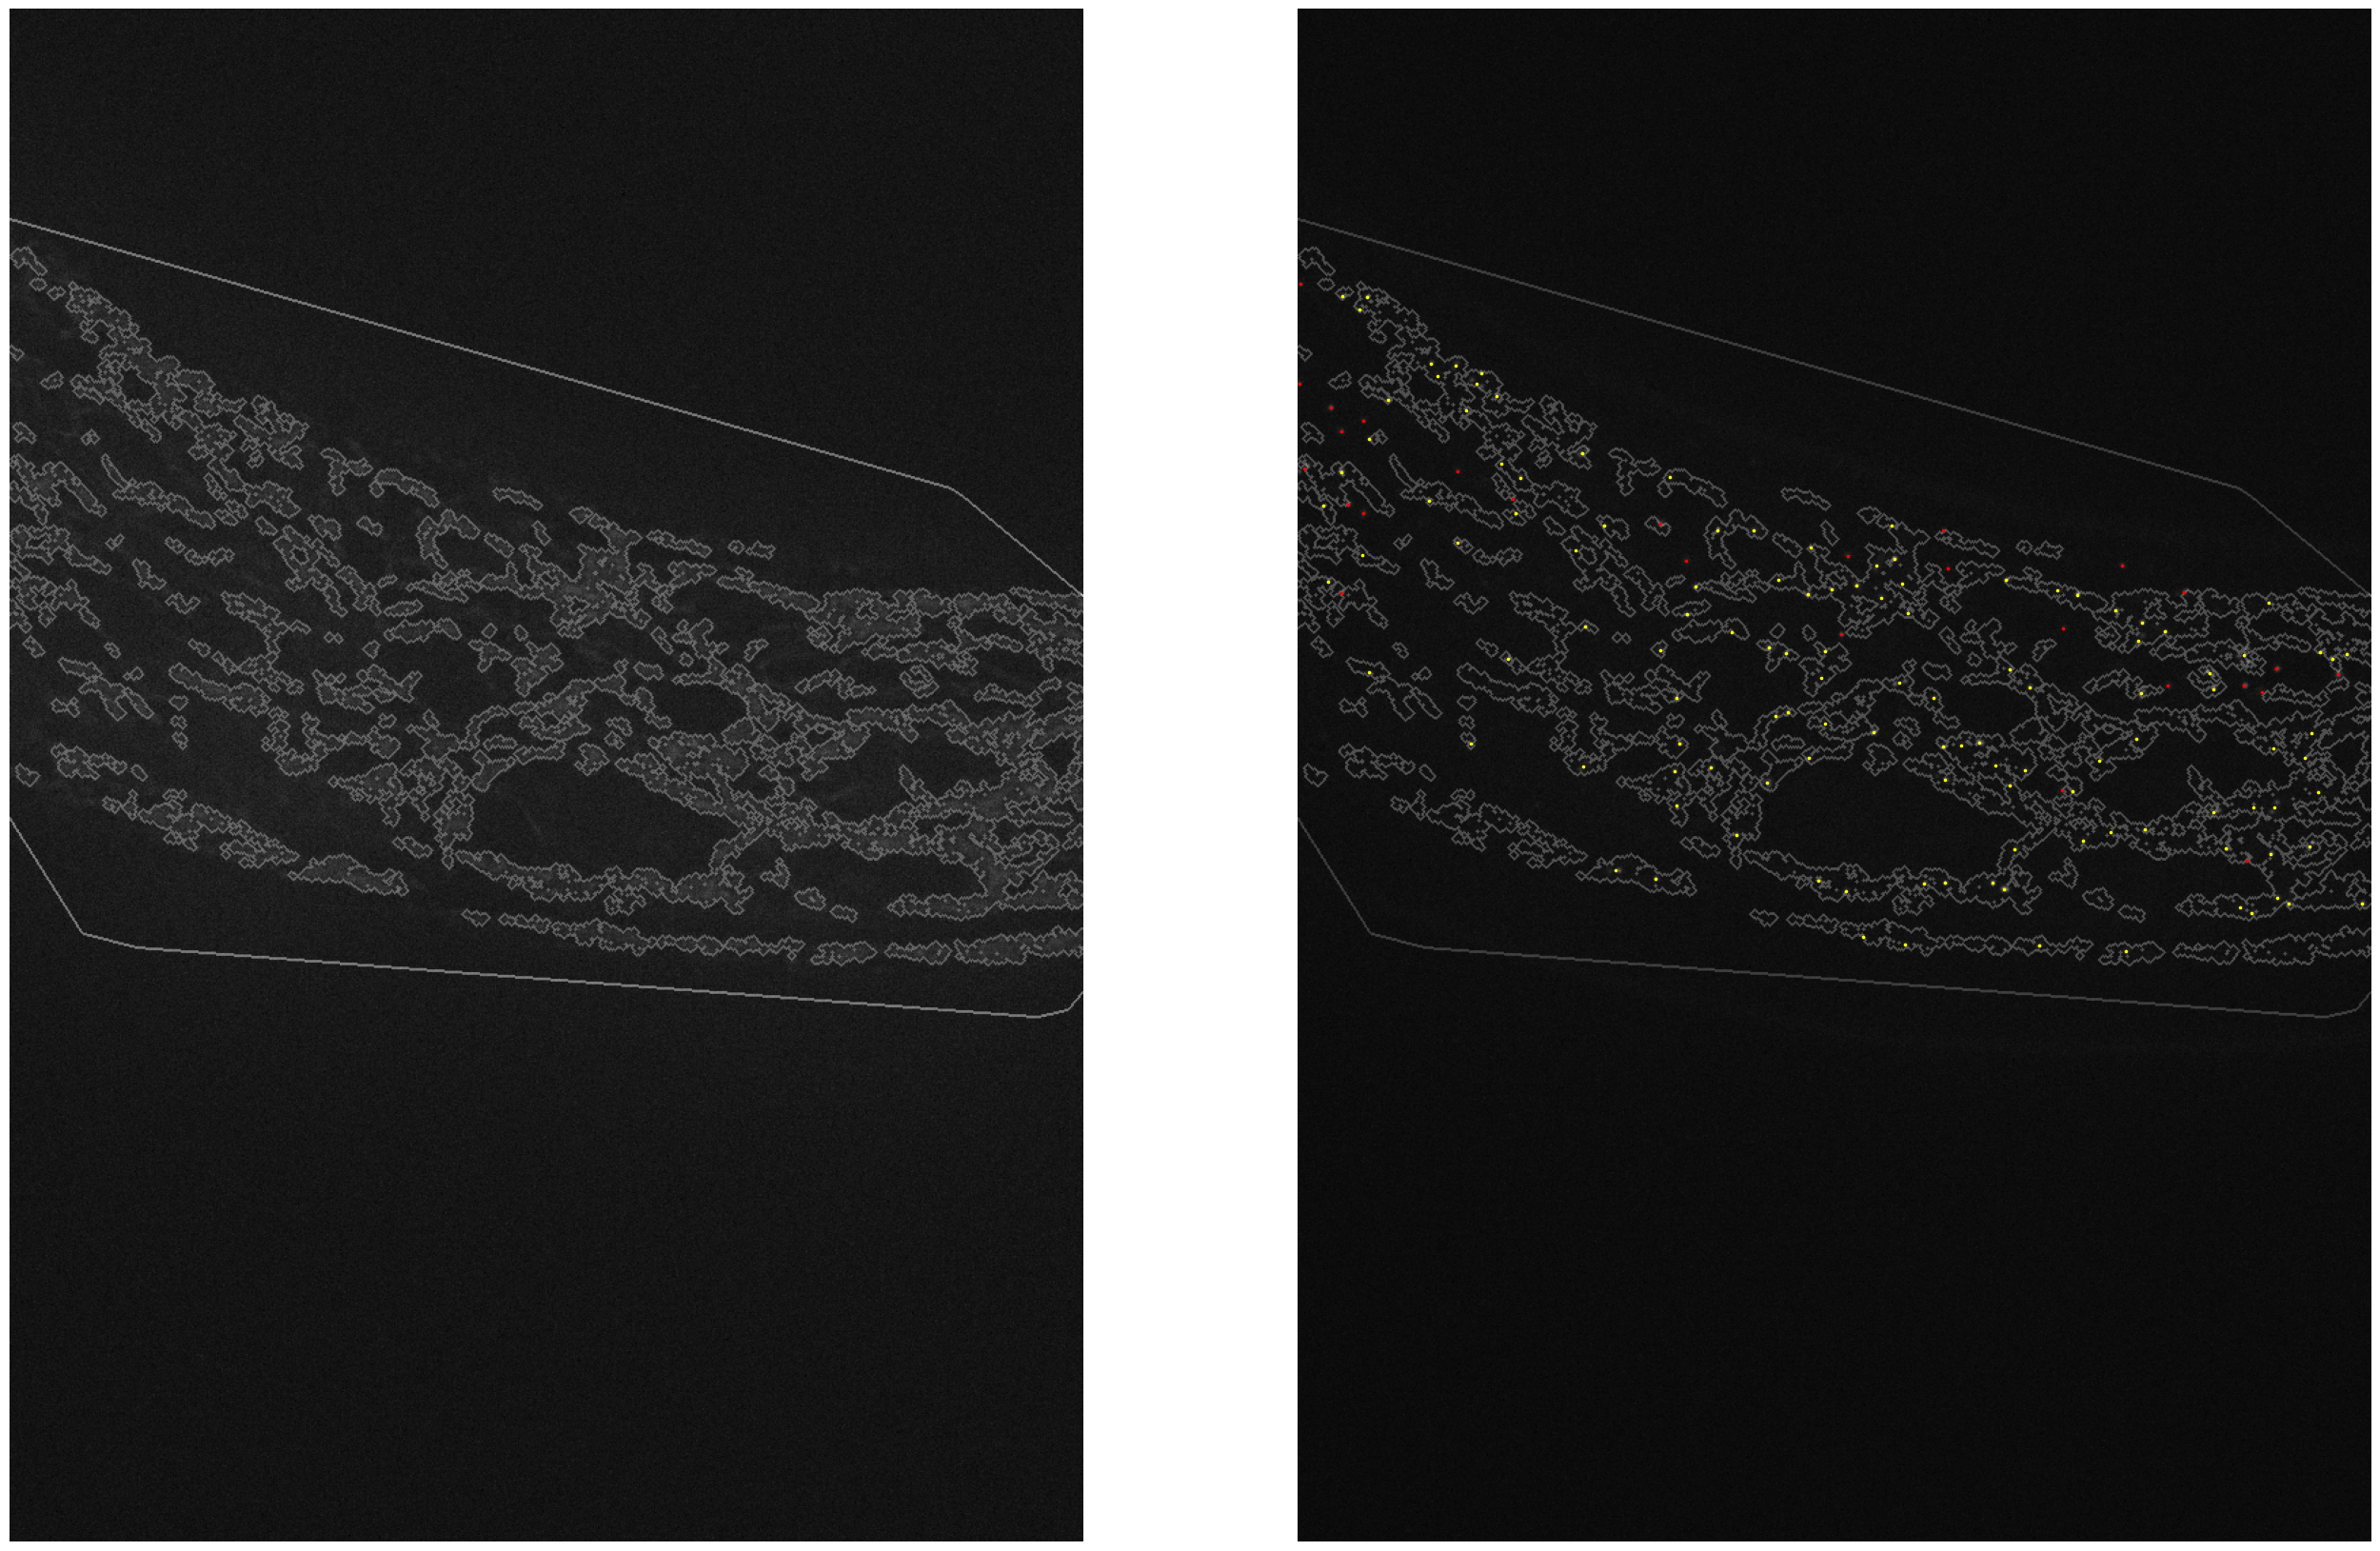

In [15]:
# Create output directory if it does not already exist
os.makedirs(output_directory, exist_ok=True)

# Get all files from data directory
contents = os.listdir(data_directory)

for c in contents:
    if (os.path.isfile(os.path.join(data_directory, c)) and c.endswith(".nd2")):
        print(f"Processing {c}")
        
        # Create a BioImage reader
        reader = BioImage(os.path.join(data_directory, c))

        # Get number of z-planes
        size_z = reader.shape[2]
        
        # Get pixel size for image metadata
        pxSizeX = reader.physical_pixel_sizes.X
        pxSizeY = reader.physical_pixel_sizes.Y
        pxSizeZ = reader.physical_pixel_sizes.Z

        # Initialize lists for data
        list_cell_data = []
        list_cell_spots = []
        
        # Process images one z-plane at a time
        for z in range(reader.shape[2]):           
            
            # Read in image data - Output is [height, width, channel]
            image = reader.get_image_data("YXC", Z=z)

            # Segment the mitochondrial network
            mask_mito = segmentation.segment_mitochondria(image)

            # Check if the network exists in this image - if not, skip to next plane
            if mask_mito.sum() < (0.05 * reader.shape[3] * reader.shape[4]):
                continue

            # Segment the spots
            mask_spots = segmentation.segment_spots(image)

            # Segment the tail region
            mask_tail = segmentation.segment_tail(image)

            # Exclude any spots or mitochondria masks outside the tail region
            mask_mito = mask_mito & mask_tail
            mask_spots = mask_spots & mask_tail

            # Measure data
            props_tail = skimage.measure.regionprops(mask_tail.astype(np.uint8))
            props_mito = skimage.measure.regionprops(mask_mito.astype(np.uint8)) 

            # Measure spots
            label_spots = skimage.measure.label(mask_spots)
            props_spots = skimage.measure.regionprops(label_spots, image[:, :, 1])

            spot_centroidX = []
            spot_centroidY = []
            spot_distance_to_mito_boundary = []
            spot_is_inside = []
            
            mito_boundary = skimage.segmentation.find_boundaries(mask_mito)
            props_mito_boundary = skimage.measure.regionprops(mito_boundary.astype(np.uint8))

            for spot in props_spots:
                spot_centroidX.append(spot.centroid[1])
                spot_centroidY.append(spot.centroid[0])
            
                # Calculate the distance of a spot to the whole mito mask
                in_mito_distance = min((np.sum((spot.centroid - props_mito[0]['coords']) ** 2, axis=1)) ** 0.5)
            
                #Calculate the distance of the spot to the boundary of the mito mask
                min_distance_to_mito_boundary = min((np.sum((spot.centroid - props_mito_boundary[0]['coords']) ** 2, axis=1)) ** 0.5)
            
                # Spots less than 1 pixel away are inside
                if in_mito_distance <= 1:
                    min_distance_to_mito_boundary = - min_distance_to_mito_boundary
            
                spot_distance_to_mito_boundary.append(min_distance_to_mito_boundary)

                list_cell_spots.append({'centroidX_px': spot.centroid[1],
                                        'centroidY_px': spot.centroid[0],
                                        'centroidZ_px': z,
                                        'min_distance_to_mito_surface_um': min_distance_to_mito_boundary * pxSizeX
                                       })
                                        
            # Calculate
            mito_tail_fraction = props_mito[0]['area']/props_tail[0]['area']

            # Collate data
            curr_z_data = { 'z': z,
                            'mito_area': props_mito[0]['area'] * pxSizeX * pxSizeY,
                            'tail_area': props_tail[0]['area'] * pxSizeX * pxSizeY,
                            'mito_tail_fraction': mito_tail_fraction,
                            'mtDNA_count': len(props_spots),
                            'mtDNA_count_per_mito_area': len(props_spots) / (props_mito[0]['area'] * pxSizeX * pxSizeY),
                            'mtDNA_inside_count': sum(i < 1 for i in spot_distance_to_mito_boundary),
                            'mtDNA_outside_count': sum(i >= 1 for i in spot_distance_to_mito_boundary),
                            'mtDNA_average_distance_to_mito_surface': np.mean(spot_distance_to_mito_boundary) }
            
            list_cell_data.append(curr_z_data)            

            # Make some plots
            outline_tail = skimage.segmentation.find_boundaries(mask_tail)
            outline_mito = skimage.segmentation.find_boundaries(mask_mito)

            
            plt.clf()
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(32, 24))
            ax1.imshow(image[:, :, 0], cmap='gray')
            ax1.imshow(outline_tail, cmap='gray', alpha=0.5)
            ax1.imshow(outline_mito, cmap='gray', alpha=0.25)
            ax1.axis('off')
            
            ax2.imshow(image[:, :, 1] * 10, cmap='gray')
            ax2.imshow(outline_tail, cmap='gray', alpha=0.25)
            ax2.imshow(outline_mito, cmap='gray', alpha=0.25)
            for s in range(len(spot_centroidX)):
                if spot_distance_to_mito_boundary[s] > 0:
                    ax2.scatter(spot_centroidX[s], spot_centroidY[s], 10, marker='.', color=[1, 0, 0])
                else:
                    ax2.scatter(spot_centroidX[s], spot_centroidY[s], 10, marker='.', color=[1, 1, 0])
            ax2.axis('off')

            # Save data
            fn = os.path.splitext(os.path.basename(c))[0]
            plt.savefig(os.path.join(output_directory, fn + '_Z=' + str(z) + '.png'), bbox_inches='tight')

        df_cell_data = pd.DataFrame(list_cell_data)
        df_cell_data.to_csv(os.path.join(output_directory, fn + "_cell.csv"), index=False)

        df_spot_data = pd.DataFrame(list_cell_spots)
        df_spot_data.to_csv(os.path.join(output_directory, fn + "_spots.csv"), index=False)        

        df_spot_data["min_distance_to_mito_surface_um"].hist(bins=np.arange(-2, 5, 0.25))
        plt.savefig(os.path.join(output_directory, fn + "_spots.png"))

        plt.close('all')